In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Install

In [ ]:
cd /content/gdrive/MyDrive/JMSE2022/MoldScan/

/content/gdrive/MyDrive/JMSE2022/MoldScan


In [ ]:
!pip install pyntcloud
!pip install open3d
!pip install tensorboardx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import torch
need_pytorch3d=False
import datetime
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.9") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{torch.__version__[0:5:2]}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
import tqdm
#%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['savefig.dpi'] = 80
#mpl.rcParams['figure.dpi'] = 80

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
import pandas as pd


from pytorch3d import structures
from pyntcloud import PyntCloud
from tensorboardX import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torch import autograd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
import numpy as np
import math as m
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d
import open3d as o3d
import os
from pyntcloud import PyntCloud
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

# Auxiliary Functions

In [ ]:
z_dim=32
def Filter1(PCs):
  pointsAE = np.load('./PC_Arrays/finalpoints22048.npy',allow_pickle=True)
  #pointsAE= (pointsAE - (-0.5)) / (0.5 - (-0.5))
  aligned_Tensor = PointcloudDatasetNoisy('DATA_DIR', pointsAE)
  aligned_dataloader = DataLoader(aligned_Tensor, num_workers=0, shuffle=True, batch_size=1)
  aligned_Tensor2 = PointcloudDatasetNoisy(DATA_DIR, PCs)
  aligned_dataloader2 = DataLoader(aligned_Tensor2, num_workers=0, shuffle=True, batch_size=1)
  min= 5.1408e-05
  max=0.0004
  x=aligned_dataloader.dataset[1].float().to(device)
  x= x.unsqueeze(0)
  final_points=PCs
  chamf_list_Org=[]
  size=len(PCs)
  remove=[]
  start=0
  for i in range(1):
    for j in tqdm(range(0,size)):
        if not j in remove:
          y=aligned_dataloader2.dataset[j].float().to(device)
          y= y.unsqueeze(0)
          loss_chamf,_=chamfer_distance(x,y)
          chamf_list_Org.append(loss_chamf.detach().cpu().numpy())
          if loss_chamf<min:
            remove.append(j)
          if loss_chamf>max:
            remove.append(j)
        
  #Sturge’s Rule
  print("Removed Points:",len(remove),".Remaining Points:",size-len(remove))
  bn=int(np.round(1+3.322*np.log10(30)))
#_ = plt.hist(chamf_list, bins=np.array(8))
  _ = plt.hist(chamf_list_Org, bins=bn)
  plt.title("Histogram (Fake PC)")
  print("Average:",np.mean(chamf_list_Org),"Std",np.std(chamf_list_Org))
  return remove

def Filter2(chamf_list,desc=False):
  min= 5.1408e-05
  max=0.0004
  avg=(min+max)/2
  chamf_list=np.where(chamf_list==0,avg,chamf_list)
  ct_idx=np.zeros(len(chamf_list))
  remove=[]
  control=2
  while control>0:
  #print(chamf_list)
    for i in range(len(chamf_list)):
      a=chamf_list[:,i]
      ct_idx[i]=np.count_nonzero(a < min)
    id=np.argmax(ct_idx)
    if ct_idx[id]>0:
      remove.append(id)
      chamf_list[id,:]=avg
      chamf_list[:,id]=avg
    control=np.average(ct_idx)
  if desc==True:
    print(remove)
    print(np.average(ct_idx))
    print(ct_idx)
  return remove

def genPCs(number_PCs=10000,z_dim=z_dim,it=0,zf=0):
  if it==0:
    zf = torch.randn(number_PCs, z_dim).to(device)
  else:
    cov=np.cov(np.transpose(zf))
    mu=np.mean(zf)
    mean=mu*np.ones(32)
    print(mu)
    z_controlled= np.random.multivariate_normal(mean, cov,number_PCs)
    z_controlled.shape
    zf=torch.from_numpy(z_controlled).to(device)
    zf=zf.type(torch.cuda.FloatTensor)
  with torch.no_grad():
    gen_out, _ = generator(zf)
    out_data = autoencoder.decode(gen_out)
    out_data = out_data.detach().cpu().numpy()
  np.save('PC_Arrays/It-'+str(it)+'-PCs-'+str(out_data.shape[0])+'.npy', out_data)
  np.save('PC_Arrays/It-'+str(it)+'-Zs-'+str(out_data.shape[0])+'.npy', zf.detach().cpu().numpy())
  return out_data,zf.detach().cpu().numpy()

def RemovePCs(remove=[],PCs=[],z=[]):
  pointsAE2=[]
  zf=[]
  for i in range(len(PCs)):
    if  not i in remove:
      pointsAE2.append(PCs[i])
      #zf.append(z[i])
  return pointsAE2,zf

def chamf_Mat(it=0,PCs=[]):
  aligned_Tensor2 = PointcloudDatasetNoisy('DATA_DIR', PCs)
  aligned_dataloader2 = DataLoader(aligned_Tensor2, num_workers=0, shuffle=True, batch_size=1)
  chamf_list=np.zeros((len(PCs),len(PCs)))
  for i in tqdm(range(len(PCs))):
    x=aligned_dataloader2.dataset[i].float().to(device)
    x= x.unsqueeze(0)
    for j in range(len(PCs)):
        y=aligned_dataloader2.dataset[j].float().to(device)
        y= y.unsqueeze(0)
        loss_chamf,_=chamfer_distance(x,y)
        chamf_list[i][j]=loss_chamf.detach().cpu().numpy()
  np.save('PC_Arrays/Pairs-Org-'+str(it)+'.npy', chamf_list)
  return chamf_list

In [ ]:
def generate_noisy(shrink,pointsAE2,whole=False):
  if whole==False:
    parts=shrink
  else:
    parts=1
  radius=0.1
  org_size=2048
  for j in range(parts):
    if j ==0:
      pointsAE = pointsAE2
    else:
      pointsAE = np.array(list_new_data)
      size=pointsAE.shape[1]
    min=np.ceil(org_size*(100-(j+1)*shrink/parts)/100)
    list_new_data=[]
    for i in range(len(pointsAE)):
      k=0
      shape=0
      while (shape<min or  shape>(min+3)):
        pcd=o3d.geometry.PointCloud()
        pcd.points=o3d.utility.Vector3dVector(pointsAE[i])
        points = np.asarray(pcd.points)
  # Defining a new center
        if k%2000==0:
          center=pcd.points[np.random.randint(pointsAE.shape[1])]
          #radius=0.1 
  # Defining a new raidius
        k=k+1
  # Calculating the distances
        distances = np.linalg.norm(points - center, axis=1)
  # removing points
        pcd.points = o3d.utility.Vector3dVector(points[distances >= radius])
        points = np.asarray(pcd.points)
        shape=points.shape[0]
        if shape<min:
          radius=radius-0.0001
        if shape>min:
          radius=radius+0.0001
      print("Reduction Number:",j,"/processing sample:",i,"/iteration:",k,"/shape:",shape,"/radius:",radius)
  #Saving the data
      list_new_data.append(points[:int(min)])
  np.save('PC_Arrays/Validation_Dataset/list_point_noisy-3-'+str(org_size)+'-'+str(shrink)+'.npy', list_new_data)

In [ ]:
def centroid(arrdwn):
  cx=0
  cy=0
  cz=0
  for i in range(len(arrdwn)):
    cx=cx+arrdwn[i][0]
    cy=cy+arrdwn[i][1]
    cz=cz+arrdwn[i][2]
  cx=cx/len(arrdwn)
  cy=cy/len(arrdwn)
  cz=cz/len(arrdwn)
  #print("the centroid is at:",cx,cy,cz)
  return cx,cy,cz

In [ ]:
def MoveScale3D(a,dx,dy,dz,s):
  T=np.array([[s,0,0,0],[0,s,0,0],[0,0,s,0],[dx,dy,dz,1]])
  aux=np.ones((a.shape[0],a.shape[1]+1))
  aux[:,:-1] = a
  a=aux@T
  a=a[:,[0,1,2]]
  return a

In [ ]:
def normalize(x,mu,std):
  x=1+(x-mu)/std
  return x

In [ ]:
def plot(points,show=False):
  input=points
  #inputt = points[0,:,:]
  #inputt = inputt.permute([1,0]).detach().cpu().numpy()
  size=np.max(points)
  fig = plt.figure()
  ax_x = fig.add_subplot(111, projection='3d')
  x_ = input
  ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2],s=mark, marker='o')
  ax_x.set_xlim([-size,size])
  ax_x.set_ylim([-size,size])
  ax_x.set_zlim([-size,size])
  if show==True:
    ax_x.view_init(azim=1, elev=90)


In [ ]:
class PointcloudDatasetAE(Dataset):
    def __init__(self, root, list_point_clouds):
        self.root = root
        self.list_files = list_point_clouds
        
    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        points = PyntCloud.from_file(self.list_files[index])
        points.points=points.points[0:2048]
        cx=points.centroid[0]
        cy=points.centroid[1]
        cz=points.centroid[2]
        points = np.array(points.points)
        points=points[:,[0,1,2]]
        points=MoveScale3D(points,-cx,-cy,-cz,1)
        points=points/(2*np.max(points))
        points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
        points = points_normalized.astype(np.float)
        points = torch.from_numpy(points)
        
        return points

In [ ]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [ ]:
def plotList(num,list_point_clouds,show=False):
  for i in range(num):
    points = list_point_clouds[i]
    points = np.array(points)
    points=points[:,[0,1,2]]
    points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
    points = points_normalized.astype(np.float)
    inputt = points[:,:]
    fig = plt.figure()
    ax_x = fig.add_subplot(111, projection='3d')
    x_ = inputt
    ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2])
    ax_x.set_xlim([0,1])
    ax_x.set_ylim([0,1])
    ax_x.set_zlim([0,1])
    if show==True:
      ax_x.view_init(azim=1, elev=90)

In [ ]:
def angles(a,graph=False):
  fac=180/np.pi
  pca=PCA(n_components=3)
  pca.fit(a)
  eigen_vectors=pca.components_
  theta1=np.array(np.arccos(eigen_vectors))
  tx=np.pi-theta1[0][0]
  ty=np.pi/2-theta1[0][1]
  tz=np.pi/2-theta1[0][2]
  origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point
  if (graph==True):
    plt.quiver(*origin, eigen_vectors[:,0], eigen_vectors[:,1], color=['r','b','g'], scale=3)
    plt.show()
    plt.quiver(*origin, eigen_vectors[:,1], eigen_vectors[:,2], color=['r','b','g'], scale=3)
    plt.show()
    plt.quiver(*origin, eigen_vectors[:,0], eigen_vectors[:,2], color=['r','b','g'], scale=3)
    plt.show()
  return tx,ty,tz
fac=180/np.pi

In [ ]:
def Rx(theta):
  return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])
  
def Ry(theta):
  return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
  
def Rz(theta):
  return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])
fac=180/np.pi

In [ ]:
class PointcloudDatasetNoisy(Dataset):
    def __init__(self,root,list_point_clouds):
        self.root = root
        self.list_files = list_point_clouds
        
    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        points = self.list_files[index]
        points=points[:,[0,1,2]]
        points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
        points = points_normalized.astype(np.float)
        points = torch.from_numpy(points)
        
        return points

# Read Files

In [ ]:
directory = r'/content/gdrive/MyDrive/JMSE2022/MoldScan/asc/'
names=[None]*60
i=0
for filename in os.listdir(directory):
  names[i]=str(os.path.join(directory, filename))
  i=i+1

In [ ]:
pcd = o3d.io.read_point_cloud(names[0],format='xyzn')

# Remove Outliers

In [ ]:
#identify possible outlier from original set of point cloud datas without downsampling
#nb_neighbors = 20
#std_ratio = 2.0
def display_inlier_outlier(cloud, ind):
    inlier_cloud_or = cloud.select_by_index(ind)
    outlier_cloud_or = cloud.select_by_index(ind, invert=True)

# Crop Lower side

In [ ]:
cx,cy,cz=centroid(pcd.points)
points = np.asarray(pcd.points)
points=MoveScale3D(points,-cx,-cy,-cz,1)
cx,cy,cz=centroid(points)
points=MoveScale3D(points,-cx,-cy,-cz,1/np.max(points))
cx,cy,cz=centroid(points)
points.shape

(219588, 3)

In [ ]:
mark=0.5

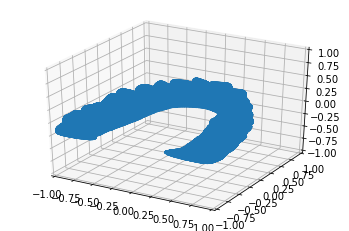

In [ ]:
plot(points)

In [ ]:
x=points[:, 0]
y=points[:, 1]
z=points[:, 2]

In [ ]:
xf=[]
yf=[]
zf=[]
f=np.min(z)+(np.max(z)-np.min(z))*.35 #Removing the 35% of the scan to keep
for i in range(len(z)):
  if z[i]>f:
    xf.append(x[i])
    yf.append(y[i])
    zf.append(z[i])


In [ ]:
x=np.array(xf)
y=np.array(yf)
z=np.array(zf)
fpoints=np.array([x,y,z])
fpoints=fpoints.transpose()
fpoints.shape

In [ ]:
plot(fpoints)

In [ ]:
pcd_crop=o3d.geometry.PointCloud()
pcd_crop.points=o3d.utility.Vector3dVector(fpoints)

# Downsampling

In [ ]:
downpcd = pcd_crop.voxel_down_sample(voxel_size=0.04651)
cl, ind = downpcd.remove_radius_outlier(nb_points=16, radius=0.05)
arrdwn = np.array(downpcd.points)
df = pd.DataFrame(arrdwn, columns=['X axis', 'Y axis', 'Z axis'])
print(arrdwn.shape)

(2048, 3)


# Centering it

In [ ]:
cx,cy,cz=centroid(arrdwn)
print("the centroid is at:",cx,cy,cz)
arrdwn=MoveScale3D(arrdwn,-cx,-cy,-cz,1)
cx,cy,cz=centroid(arrdwn)
print("the centroid is at:",cx,cy,cz)
arrdwn=MoveScale3D(arrdwn,-cx,-cy,-cz,1/(2*np.max(arrdwn)))

the centroid is at: 0.027002755938609208 0.05416115071991211 0.05773152517826911
the centroid is at: 4.87890977618477e-18 -7.685976963385521e-18 -5.164868099177822e-17


In [ ]:
maxarr=np.max(arrdwn)
print("the new maximun value is:",maxarr)

the new maximun value is: 0.5


In [ ]:
arrdwn

In [ ]:
dw1=o3d.geometry.PointCloud()
dw1.points=o3d.utility.Vector3dVector(arrdwn)

In [ ]:
np.array(dw1.points)

array([[ 0.00716614,  0.38851642,  0.074533  ],
       [-0.218902  ,  0.33885577,  0.07202679],
       [-0.219931  ,  0.33188987,  0.07438649],
       ...,
       [ 0.3278431 , -0.02671808,  0.03863676],
       [-0.11802989,  0.30772892,  0.07444595],
       [ 0.31749447, -0.01630176,  0.03418594]])

# Mirroring

In [ ]:
arrdwn2=arrdwn
for i in range(len(arrdwn2)):
  arrdwn2[i][0]=-arrdwn2[i][0]
arrdwn2

array([[-0.00716614,  0.38851642,  0.074533  ],
       [ 0.218902  ,  0.33885577,  0.07202679],
       [ 0.219931  ,  0.33188987,  0.07438649],
       ...,
       [-0.3278431 , -0.02671808,  0.03863676],
       [ 0.11802989,  0.30772892,  0.07444595],
       [-0.31749447, -0.01630176,  0.03418594]])

In [ ]:
dw2=o3d.geometry.PointCloud()
dw2.points=o3d.utility.Vector3dVector(arrdwn2)

In [ ]:
np.array(dw2.points)

array([[-0.00716614,  0.38851642,  0.074533  ],
       [ 0.218902  ,  0.33885577,  0.07202679],
       [ 0.219931  ,  0.33188987,  0.07438649],
       ...,
       [-0.3278431 , -0.02671808,  0.03863676],
       [ 0.11802989,  0.30772892,  0.07444595],
       [-0.31749447, -0.01630176,  0.03418594]])

In [ ]:
print("the new maximun value is:",np.max(arrdwn2),"and the new minimun is at",np.min(arrdwn2))

the new maximun value is: 0.5 and the new minimun is at -0.5299701048332721


In [ ]:
print("the new maximun value is:",np.max(arrdwn1),"and the new minimun is at",np.min(arrdwn1))

the new maximun value is: 0.5 and the new minimun is at -0.5299701048332721


In [ ]:
  if (len(arrdwn)!=2048):
    print("Error in file")

# Write PLY

In [ ]:
ROOT_DIR = './2048Samples/'
if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
newfile='test.ply'
o3d.io.write_point_cloud(ROOT_DIR+newfile, dw1)
o3d.io.write_point_cloud(ROOT_DIR+'mirror'+newfile, dw2)

True

# Test size

In [ ]:
points = PyntCloud.from_file(ROOT_DIR+newfile)
points2 = PyntCloud.from_file(ROOT_DIR+'mirror'+newfile)
points = np.array(points.points[0:2048])
points2 = np.array(points2.points[0:2048])
points=points[:,[0,1,2]]
points2=points2[:,[0,1,2]]
points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
points2_normalized = (points2 - (-0.5)) / (0.5 - (-0.5))
points = points_normalized.astype(np.float)
points2 = points2_normalized.astype(np.float)
print(points.shape)
print(points2.shape)

(2048, 3)
(2048, 3)


(0.0, 1.0)

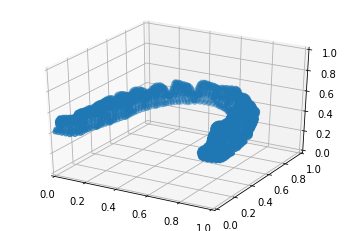

In [ ]:
inputt = points[:,:]
fig = plt.figure()
ax_x = fig.add_subplot(111, projection='3d')
x_ = inputt
ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2])
ax_x.set_xlim([0,1])
ax_x.set_ylim([0,1])
ax_x.set_zlim([0,1])


(0.0, 1.0)

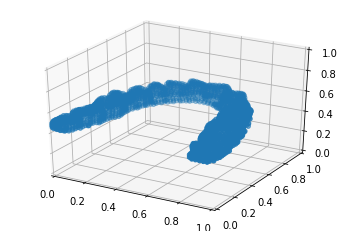

In [ ]:
inputt = points2[:,:]
fig = plt.figure()
ax_x = fig.add_subplot(111, projection='3d')
x_ = inputt
ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2])
ax_x.set_xlim([0,1])
ax_x.set_ylim([0,1])
ax_x.set_zlim([0,1])

# Iteration over every file

In [ ]:
ROOT_DIR = './2048Samples/'+str(datetime.datetime.now())+'/'
if not os.path.exists(ROOT_DIR):
  os.makedirs(ROOT_DIR)
for k in range(len(names)):
  #Initializing variables
  pcd=None
  downpcd=None
  namefile=None
  namefile='Sample:'+str(k)+'-Degrees:'+names[k][46:50]+'.ply'
  newdim=0
  #NewSize
  lwb=10000
  upb=10005
  n=1
  #Reduction size
  red=0.04651
  #Scaling factor
  scl=2
  #read file as xyzn
  pcd = o3d.io.read_point_cloud(names[k],format='xyzn')
  #remove outliers
  cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20,std_ratio=2.0)
  #crop it
  cx,cy,cz=centroid(pcd.points)
  points = np.asarray(pcd.points)
  points=MoveScale3D(points,-cx,-cy,-cz,1)
  cx,cy,cz=centroid(points)
  factor=2*np.max(np.abs(points))
  points=MoveScale3D(points,-cx,-cy,-cz,1/factor)
  x=points[:, 0]
  y=points[:, 1]
  z=points[:, 2] 
  xf=[]
  yf=[]
  zf=[]
  f=np.min(z)+(np.max(z)-np.min(z))*.35 #Removing the 35% of the scan
  for i in range(len(z)):
    if z[i]>f:
      xf.append(x[i])
      yf.append(y[i])
      zf.append(z[i])
  x=np.array(xf)
  y=np.array(yf)
  z=np.array(zf)
  fpoints=np.array([x,y,z])
  fpoints=fpoints.transpose()
  # Generate new pcd
  pcd_crop=o3d.geometry.PointCloud()
  pcd_crop.points=o3d.utility.Vector3dVector(fpoints)
  #donwsampling it
  while newdim<lwb or newdim >upb:
    downpcd = pcd_crop.voxel_down_sample(voxel_size=red)
  #generate array of values
    arrdwn = np.array(downpcd.points)
    newdim=len(arrdwn)
    if n==1:
      print("Processing file",namefile)
    if newdim<lwb:
      red=red-0.005/(n*(0.5))
      print("The new dim is:",newdim,"/file:",k,"/iteration",n)
    if newdim>upb:
      red=red+0.005/(n*(0.5))
      print("The new dim is:",newdim,"/file:",k,"/iteration:",n)
    if (n<500):
      n=n+1
    else:
      n=1
      upb=upb+2
  print("The final dim is:",newdim)
  #centering
  cx,cy,cz=centroid(arrdwn)
  arrdwn=MoveScale3D(arrdwn,-cx,-cy,-cz,1)
  cx,cy,cz=centroid(arrdwn)
  #factor=np.max(np.abs(arrdwn))
  arrdwn=MoveScale3D(arrdwn,-cx,-cy,-cz,1)
  #First File
  dw1=o3d.geometry.PointCloud()
  dw1.points=o3d.utility.Vector3dVector(arrdwn)
  #Mirror it
  arrdwn2=arrdwn
  for i in range(len(arrdwn2)):
    arrdwn2[i][0]=-arrdwn2[i][0]
  #Second File
  dw2=o3d.geometry.PointCloud()
  dw2.points=o3d.utility.Vector3dVector(arrdwn2)
  #Save as .ply
  o3d.io.write_point_cloud(ROOT_DIR+namefile, dw1)
  o3d.io.write_point_cloud(ROOT_DIR+'Mirror'+namefile, dw2)

Streaming output truncated to the last 5000 lines.
The new dim is: 9995 /file: 5 /iteration 47
The new dim is: 10387 /file: 5 /iteration: 48
The new dim is: 10013 /file: 5 /iteration: 49
The new dim is: 9598 /file: 5 /iteration 50
The final dim is: 10000
Processing file Sample:6-Degrees:7 de.ply
The new dim is: 474 /file: 6 /iteration 1
The new dim is: 764 /file: 6 /iteration 2
The new dim is: 1028 /file: 6 /iteration 3
The new dim is: 1273 /file: 6 /iteration 4
The new dim is: 1523 /file: 6 /iteration 5
The new dim is: 1804 /file: 6 /iteration 6
The new dim is: 2063 /file: 6 /iteration 7
The new dim is: 2336 /file: 6 /iteration 8
The new dim is: 2667 /file: 6 /iteration 9
The new dim is: 2982 /file: 6 /iteration 10
The new dim is: 3303 /file: 6 /iteration 11
The new dim is: 3682 /file: 6 /iteration 12
The new dim is: 4077 /file: 6 /iteration 13
The new dim is: 4498 /file: 6 /iteration 14
The new dim is: 4952 /file: 6 /iteration 15
The new dim is: 5426 /file: 6 /iteration 16
The new di

# Test New Data


In [ ]:
#directory = ROOT_DIR
directory = './2048Samples/2021-09-10 19:57:24.017751/'
names2=[None]*120
i=0
for filename in os.listdir(directory):
  names2[i]=str(os.path.join(directory, filename))
  i=i+1

In [ ]:
for i in range(len(names2)):
  points = PyntCloud.from_file(names2[i])
  points = np.array(points.points)
  points=points[:,[0,1,2]]
  points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
  points = points_normalized.astype(np.float)
  inputt = points[:,:]
  fig = plt.figure()
  ax_x = fig.add_subplot(111, projection='3d')
  x_ = inputt
  ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2])
  ax_x.set_xlim([0,1])
  ax_x.set_ylim([0,1])
  ax_x.set_zlim([0,1])

Output hidden; open in https://colab.research.google.com to view.

# Align point Clouds 


In [ ]:
  points = PyntCloud.from_file(names2[99])
  points = np.array(points.points)
  points=points[:,[0,1,2]]
  cx,cy,cz=centroid(points)
  points=MoveScale3D(points,-cx,-cy,-cz,1)
  cx,cy,cz=centroid(points)
  points=MoveScale3D(points,-cx,-cy,-cz,1/np.max(points))

In [ ]:
points.shape

(2505, 3)

In [ ]:
fac

57.29577951308232

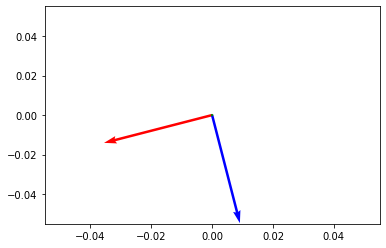

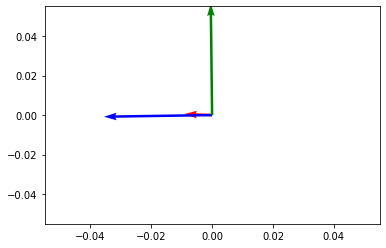

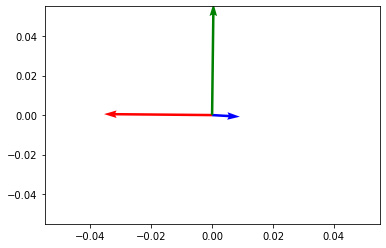

14.435127256752248 -14.425940191272765 0.504067040599177


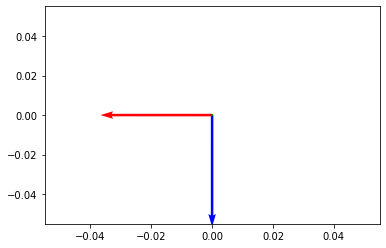

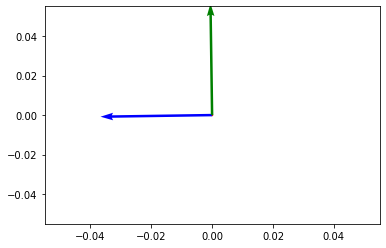

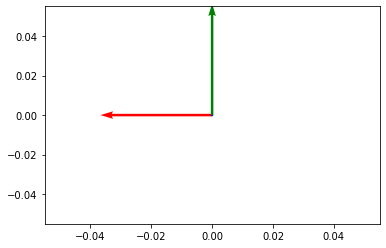

0.008616337493209395 0.008616337487497119 5.6999229335256716e-09


In [ ]:
tx,ty,tz=angles(points,graph=True)
print(tx*fac,ty*fac,tz*fac)
if tx>100*(1/fac):
  tx=tx-np.pi
if ty>0:
  tx=-tx
pointsf=points@Rz(tx)@Ry(tz)
tx1,ty1,tz1=angles(pointsf,True)
print(tx1*fac,ty1*fac,tz1*fac)

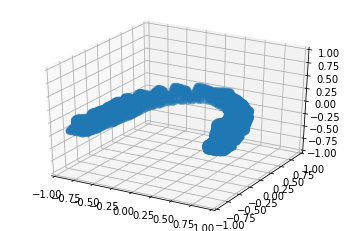

In [ ]:
plot(points)

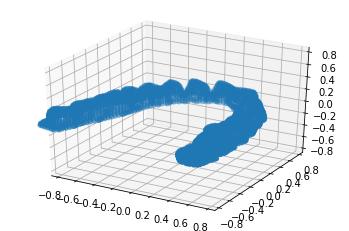

In [ ]:
plot(pointsf)

In [ ]:
  x=pointsf[:, 0]
  y=pointsf[:, 1]
  z=pointsf[:, 2] 

In [ ]:
x.shape

(2103, 1)

## Iteration 

In [ ]:
aligned_points=[]
for i in range(len(names2)):
  print("Processing File:",i)
  points = PyntCloud.from_file(names2[i])
  points = np.array(points.points)
  points=points[:,[0,1,2]]
  '''cx,cy,cz=centroid(points)
  points=MoveScale3D(points,-cx,-cy,-cz,1)
  cx,cy,cz=centroid(points)
  points=MoveScale3D(points,-cx,-cy,-cz,1/np.max(points))
  tx,ty,tz=angles(points,graph=False)
  if tx>100*(1/fac):
    tx=tx-np.pi
  if ty>0:
    tx=-tx
  pointsf=np.array(points@Rz(tx)@Ry(tz))
  _,_,_=angles(pointsf,True)'''
  aligned_points.append(points)
aligned_points=np.array(aligned_points)
np.save('aligned_points.npy', aligned_points)

# Align Points O3D

In [ ]:
#directory = ROOT_DIR
directory = './2048Samples/2021-09-10 19:57:24.017751/'
names2=[]
i=0
k=0
for filename in os.listdir(directory):
  if i%2==0:
    names2.append(str(os.path.join(directory, filename)))
  i=i+1

In [ ]:
indices = np.arange(60)
names_keep2,names_rem, _,_ = train_test_split(indices, indices, test_size=0.5, random_state=42)
print(len(names_keep2))

30


In [ ]:
names_rem

array([ 0,  5, 36, 45, 13, 54, 33, 48, 12, 57, 46, 50, 31,  3, 52, 17,  8,
        6, 40,  4, 43, 19, 34, 58, 25, 56, 15, 27,  9, 30])

In [ ]:
names_keep2.shape

(30,)

In [ ]:
np.save('PC_Arrays/Indices_Keep2.npy', np.array([names_keep2,names2]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
np.save('PC_Arrays/Indices_rem2.npy', np.array([names_rem,names2]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
PC_keep=[]
for i in range(len(names_keep2)):
  tref=o3d.io.read_point_cloud(names2[names_keep2[i]])
  PC_keep.append(tref)
#Testing Data
for i in range(len(names_rem[0:15])):
  tref=o3d.io.read_point_cloud(names2[names_rem[i]])
  PC_keep.append(tref)

In [ ]:
len(PC_keep)

45

In [ ]:
tref=PC_keep[0]
tref=np.array(tref.points)

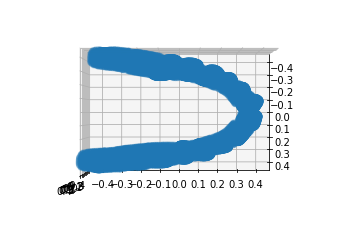

In [ ]:
plot(tref,True)

In [ ]:
np.min(tref)

-0.5031062286693242

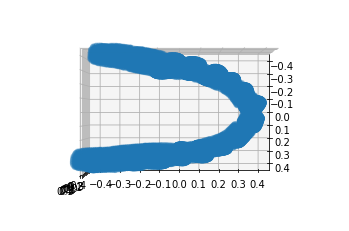

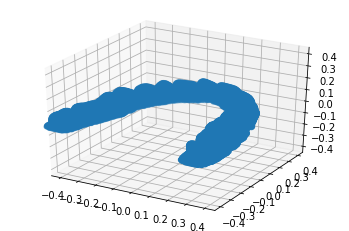

In [ ]:
tref1=tref@Rz(2/fac)
plot(tref1,True)
plot(tref1,False)

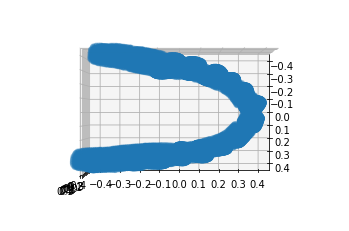

In [ ]:
tref1=tref@Rz(2/fac)@Rx(90/fac)@Rz(0/fac)@Rx(-90/fac)
plot(tref1,True)

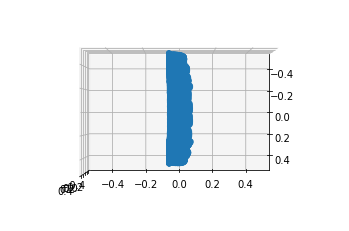

In [ ]:
tref2=tref1@Rx(90/fac)
plot(tref2,True)

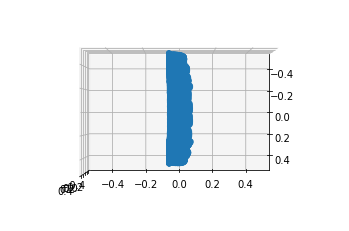

In [ ]:
tref3=tref2@Rz(-0/fac)
plot(tref3,True)

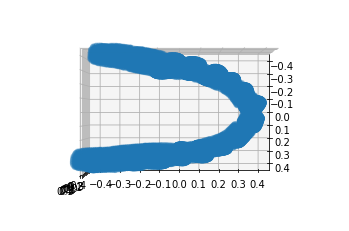

In [ ]:
tref4=tref3@Rx(-90/fac)
plot(tref4,True)

In [ ]:
i=1

In [ ]:
tref=PC_keep[i]
tref=np.array(tref.points)

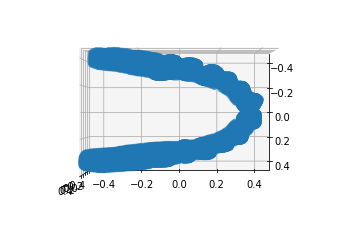

In [ ]:
plot(tref,True)

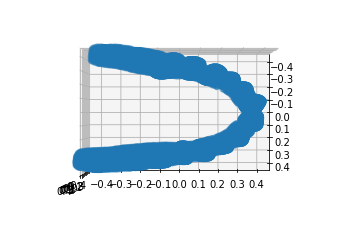

In [ ]:
tref1=tref@Rz(2/fac)@Rx(90/fac)@Rz(-0.2/fac)@Rx(-90/fac)
plot(tref1,True)

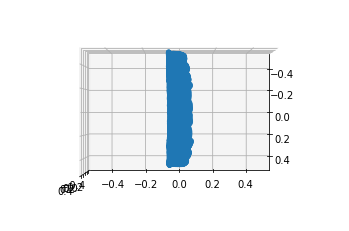

In [ ]:
tref2=tref1@Rx(90/fac)
plot(tref2,True)

In [ ]:
target = PC_keep[0]
source = PC_keep[i]
threshold = 0.05
trans_init = np.eye(4)

In [ ]:
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(source, target,threshold, np.eye(4))
print(evaluation)

Initial alignment
RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.979290e-03, and correspondence_set size of 10001
Access transformation to get result.


In [ ]:
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(source, target, threshold, trans_init,o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)

Apply point-to-point ICP
RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.974986e-03, and correspondence_set size of 10001
Access transformation to get result.


In [ ]:
transf=reg_p2p.transformation
len(reg_p2p.correspondence_set)

10001

In [ ]:
s1=np.array(source.points)
t1=np.array(target.points)
sf=source.transform(reg_p2p.transformation)
sf=np.array(sf.points)

# Iteration Over Every File

In [ ]:
tref1=PC_keep[0]
tref1=np.array(tref1.points)
tref1=tref1@Rz(2/fac)@Rx(90/fac)@Rz(0/fac)@Rx(-90/fac)
target1 = o3d.geometry.PointCloud()
target1.points=o3d.utility.Vector3dVector(tref1)
threshold = 0.001
trans_init = np.eye(4)
corresp=[]
aligned_points=[]
for i in range(len(PC_keep)):
  size=0
  num=1
  threshold = 0.01
  while size<9950:
    source = PC_keep[i]
    evaluation = o3d.pipelines.registration.evaluate_registration(source, target1,threshold, trans_init)
    reg_p2p = o3d.pipelines.registration.registration_icp(source, target1, threshold, trans_init,o3d.pipelines.registration.TransformationEstimationPointToPoint())
    transf=reg_p2p.transformation
    size=len(reg_p2p.correspondence_set)
    threshold=threshold+0.0005
    print("Procesing file:",i,"iteration:",num,"correspondence:",size)
    num=num+1
  corresp.append(len(reg_p2p.correspondence_set))
  sf=source.transform(reg_p2p.transformation)
  sf=np.array(sf.points)
  aligned_points.append(sf)

aligned_points=np.array(aligned_points)
np.save('PC_Arrays/aligned_points2.npy', aligned_points)

Procesing file: 0 iteration: 1 correspondence: 10005
Procesing file: 1 iteration: 1 correspondence: 9931
Procesing file: 1 iteration: 2 correspondence: 9946
Procesing file: 1 iteration: 3 correspondence: 9970
Procesing file: 2 iteration: 1 correspondence: 9915
Procesing file: 2 iteration: 2 correspondence: 9922
Procesing file: 2 iteration: 3 correspondence: 9929
Procesing file: 2 iteration: 4 correspondence: 9937
Procesing file: 2 iteration: 5 correspondence: 9943
Procesing file: 2 iteration: 6 correspondence: 9947
Procesing file: 2 iteration: 7 correspondence: 9955
Procesing file: 3 iteration: 1 correspondence: 5034
Procesing file: 3 iteration: 2 correspondence: 5453
Procesing file: 3 iteration: 3 correspondence: 6006
Procesing file: 3 iteration: 4 correspondence: 6840
Procesing file: 3 iteration: 5 correspondence: 7626
Procesing file: 3 iteration: 6 correspondence: 7917
Procesing file: 3 iteration: 7 correspondence: 8257
Procesing file: 3 iteration: 8 correspondence: 8476
Procesing f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


# Generate new Data

In [ ]:
aligned_points =np.load('./PC_Arrays/aligned_points2.npy',allow_pickle=True)

In [ ]:
len(aligned_points)

45

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


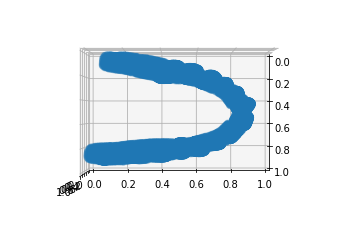

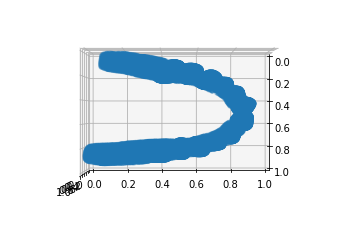

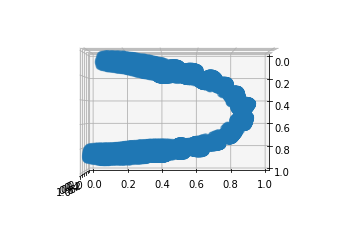

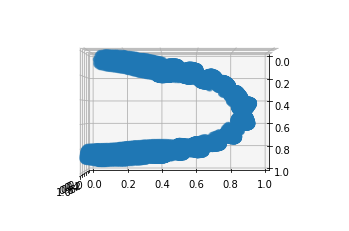

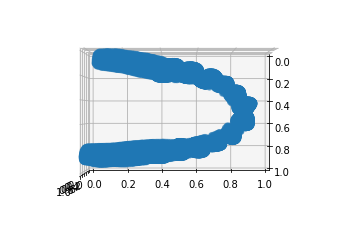

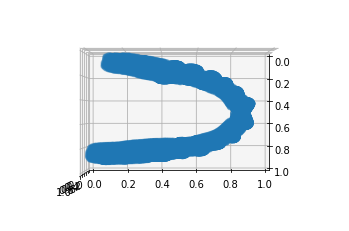

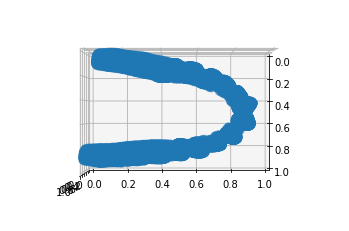

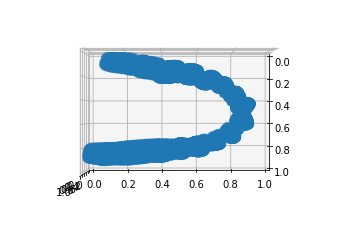

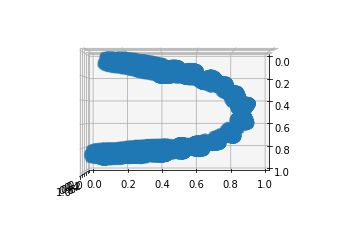

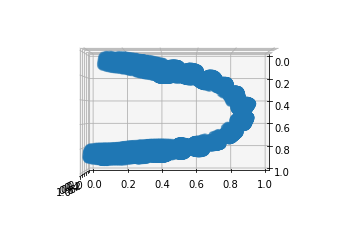

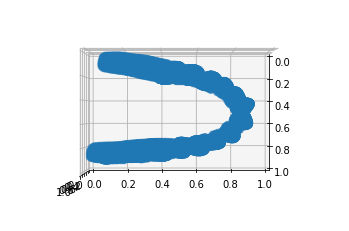

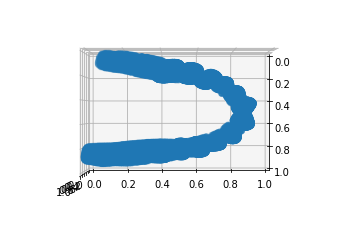

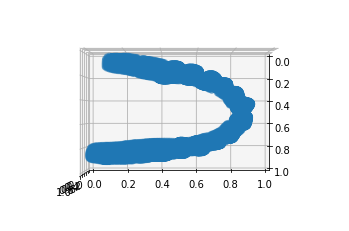

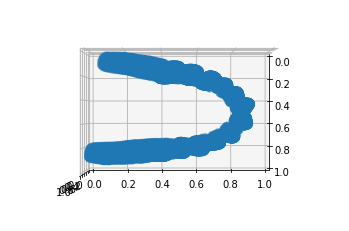

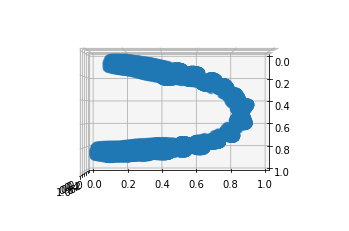

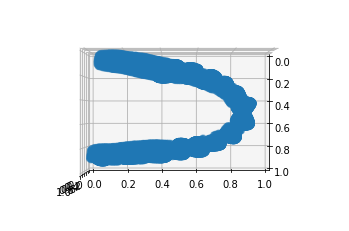

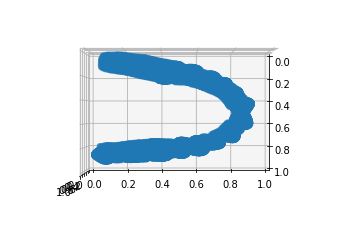

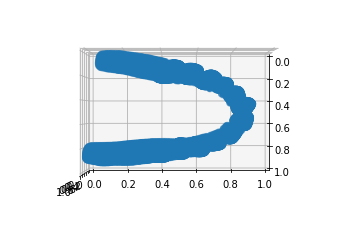

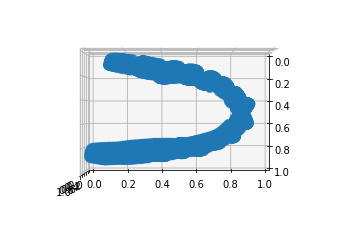

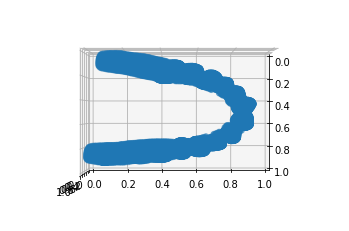

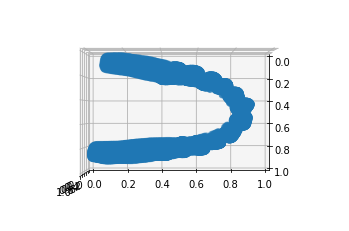

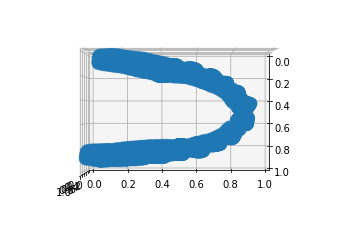

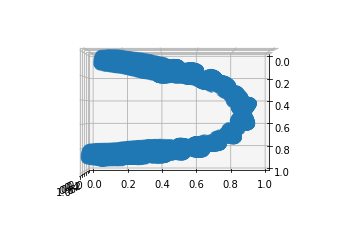

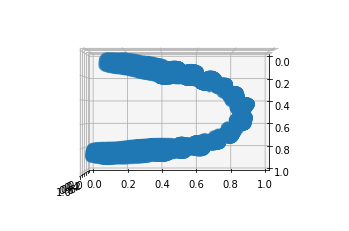

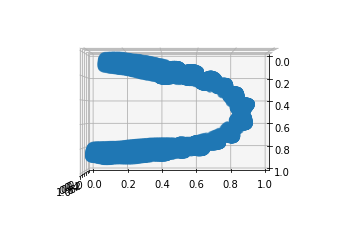

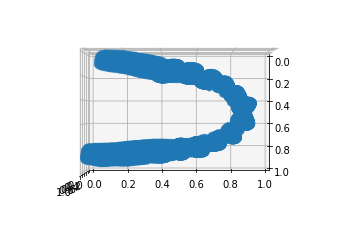

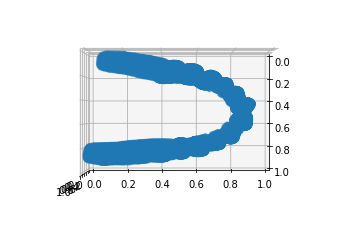

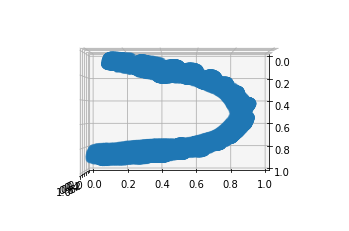

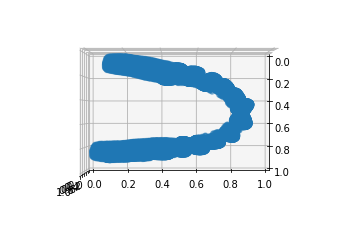

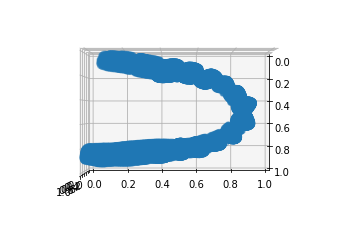

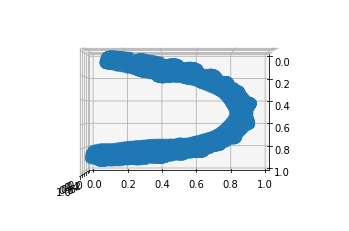

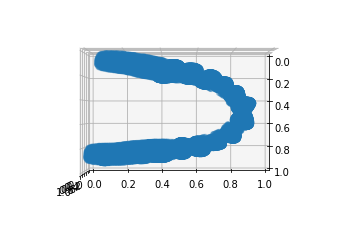

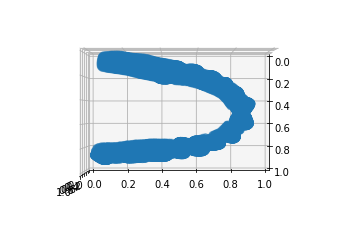

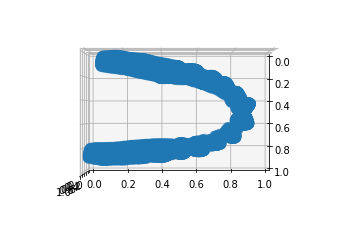

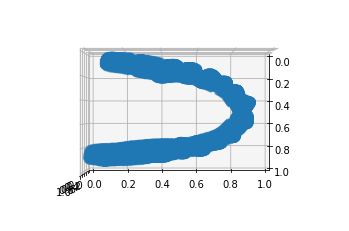

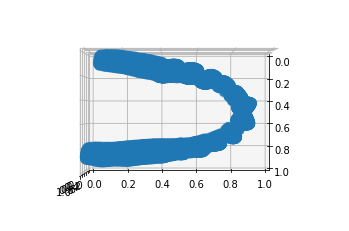

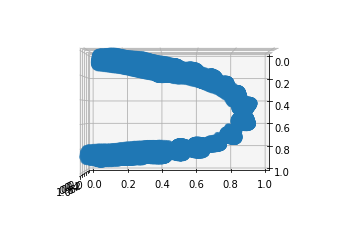

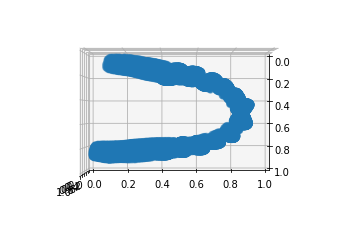

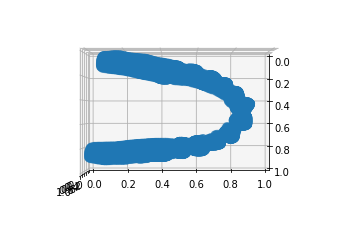

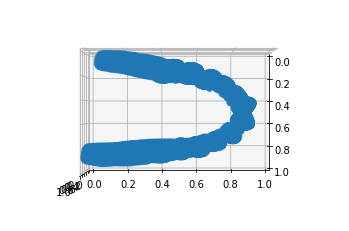

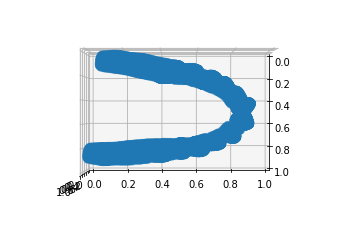

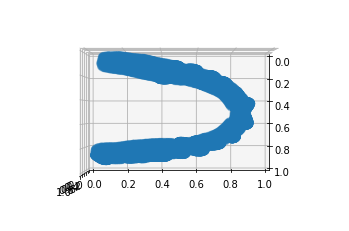

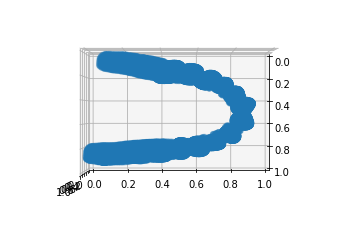

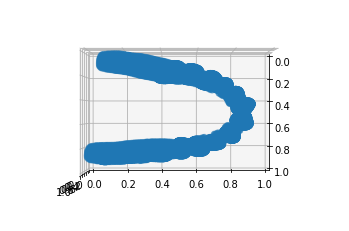

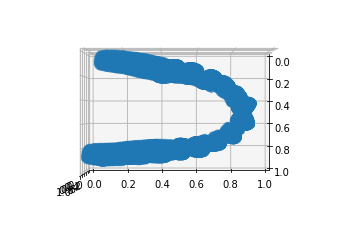

In [ ]:
plotList(45,aligned_points,True)

In [ ]:
aligned_points[0]

array([[-3.58077488e-02,  3.58050459e-01,  6.63200265e-02],
       [ 2.65273653e-01,  2.04089461e-01,  6.77745676e-02],
       [ 8.78627988e-02,  3.55012745e-01,  6.67769610e-02],
       ...,
       [ 2.48373364e-01,  4.24096982e-02,  2.13603168e-02],
       [-3.42101049e-04,  3.23132213e-01,  1.94601268e-02],
       [-3.21763544e-01,  1.47772768e-01,  2.07537923e-02]])

In [ ]:
data1=aligned_points[0]
data2=aligned_points[1]

In [ ]:
x1=data1[:,0]
x2=data2[:,0]
y1=data1[:,1]
y2=data2[:,1]

In [ ]:
print("x:",np.min(x1),np.min(x2),np.max(x1),np.max(x2),"y:",np.min(y1),np.min(y2),np.max(y1),np.max(y2))

x: -0.4993432669046261 -0.5045272649122962 0.43566103091669156 0.44071494360752744 y: -0.5163677203307188 -0.5221057902448589 0.40937825046792803 0.41277895048512303


In [ ]:
ind1_1=np.array([i for i in range(len(x1)) if x1[i]>0])
ind1_2=np.array([i for i in range(len(x1)) if x1[i]<=0])
ind2_1=np.array([i for i in range(len(x2)) if x2[i]>0])
ind2_2=np.array([i for i in range(len(x2)) if x2[i]<=0])

In [ ]:
points1_1=np.array(data1[ind1_1,:])
points1_2=np.array(data2[ind2_2,:])
points2_1=np.array(data1[ind1_2,:])
points2_2=np.array(data2[ind2_1,:])
points1=np.concatenate((points1_1,points1_2))
points2=np.concatenate((points2_1,points2_2))

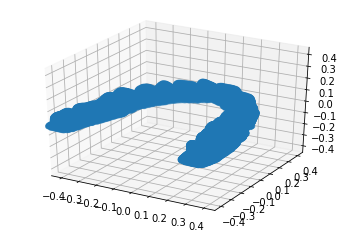

In [ ]:
plot(points2)

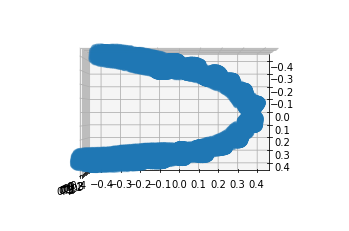

In [ ]:
plot(points2,True)

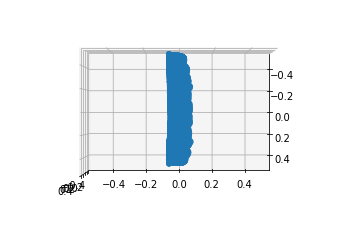

In [ ]:
plot(points2@Rx(90/fac),True)

# Split

In [ ]:
indices = np.arange(30)
train_idx,test_idx, _,_ = train_test_split(indices, indices, test_size=0.5, random_state=42)
print(len(train_idx),len(test_idx))

15 15


In [ ]:
val_idx=[]
for i in range(len(aligned_points)):
  if i not in train_idx:
    if i not in test_idx:
      val_idx.append(i)

In [ ]:
val_idx

[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]

In [ ]:
np.save('PC_Arrays/Data_Dist2.npy', np.array([train_idx,test_idx,val_idx]))

# Iteration over every file

In [ ]:
aligned_points1=aligned_points
aligned_points=aligned_points1[train_idx]

In [ ]:
aligned_points.shape

(15,)

In [ ]:
mixed_points=[]
for k in range(len(aligned_points)-1):
  print("processing file",k)
  data1=np.array(aligned_points[k])
  #isolate x (symetry axis)
  x1=data1[:,0]
  #split points in 2 arrays 
  ind1_1=np.array([i for i in range(len(x1)) if x1[i]>0])
  ind1_2=np.array([i for i in range(len(x1)) if x1[i]<=0])
  points1_1=np.array(data1[ind1_1,:])
  points1_2=np.array(data1[ind1_2,:])
  for j in range(k+1,len(aligned_points)):
    #if np.mod(j,2)==np.mod(k,2):
      data2=np.array(aligned_points[j])
      x2=data2[:,0]
    #split points in 2 arrays 
      ind2_1=np.array([i for i in range(len(x2)) if x2[i]>0])
      ind2_2=np.array([i for i in range(len(x2)) if x2[i]<=0])
      points2_1=np.array(data2[ind2_1,:])
      points2_2=np.array(data2[ind2_2,:])
    #Combine them
      points1=np.concatenate((points1_1,points2_2))
      points2=np.concatenate((points2_1,points1_2))
    #store new values
      mixed_points.append(points1)
      mixed_points.append(points2)
      del points1,points2,points2_1,points2_2,ind2_1,ind2_2,x2,data2
  del x1,points1_1,points1_2,ind1_1,ind1_2,data1
  #if k==1:
  #  break
#store new list
mixed_points2=np.array(mixed_points)
np.save('PC_Arrays/mixed_points3.npy', mixed_points)

processing file 0
processing file 1
processing file 2
processing file 3
processing file 4
processing file 5
processing file 6
processing file 7
processing file 8
processing file 9
processing file 10
processing file 11
processing file 12
processing file 13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
len(mixed_points2)

210

In [ ]:
mixed_points2=np.load('PC_Arrays/mixed_points3.npy',allow_pickle=True)
mixed_points2.shape

(210,)

In [ ]:
aligned_points[0]

array([[ 0.27240257,  0.191622  ,  0.07176816],
       [ 0.27188729,  0.18786221,  0.07037889],
       [ 0.27366501,  0.20062942,  0.07018074],
       ...,
       [ 0.25403822,  0.1925771 ,  0.02819713],
       [-0.31258004, -0.18032409, -0.01399548],
       [-0.40678643, -0.28925937,  0.01324173]])

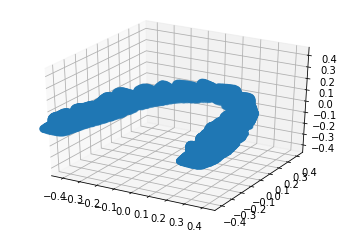

In [ ]:
plot(mixed_points2[100])

# Downsampling 2

In [ ]:
aligned_points =np.load('./PC_Arrays/aligned_points2.npy',allow_pickle=True)

In [ ]:
aligned_points.shape

(45,)

In [ ]:
mixed_points =np.load('./PC_Arrays/mixed_points3.npy',allow_pickle=True)
aligned_points =np.load('./PC_Arrays/aligned_points2.npy',allow_pickle=True)
finalPoints=[]

for i in range(len(aligned_points)):
  newdim=0
  arrdwn=None
  #NewSize
  lwb=2048
  upb=lwb+6
  n=1
  pcd_crop=o3d.geometry.PointCloud()
  pcd_crop.points=o3d.utility.Vector3dVector(aligned_points[i])
  #Reduction size
  red=0.04651
  #donwsampling it
  while newdim<lwb or newdim >upb:
    downpcd = pcd_crop.voxel_down_sample(voxel_size=red)
  #generate array of values
    arrdwn = np.array(downpcd.points)
    newdim=len(arrdwn)
    if n==1:
      print("Processing file",i)
    if newdim<lwb:
      red=red-0.005/(n*(0.5))
      print("The new dim is:",newdim,"/iteration",n)
    if newdim>upb:
      red=red+0.005/(n*(0.5))
      print("The new dim is:",newdim,"/iteration:",n)
    if (n<500):
      n=n+1
    else:
      n=1
      upb=upb+2
  print("The final dim is:",newdim)
  #Add to the list
  finalPoints.append(arrdwn[0:lwb])
print("Processing MiXED POINTS")
print("Processing MiXED POINTS")
print("Processing MiXED POINTS")
print("Processing MiXED POINTS")
print("Processing MiXED POINTS")
for i in range(len(mixed_points)):
  newdim=0
  arrdwn=None
  #NewSize
  n=1
  pcd_crop=o3d.geometry.PointCloud()
  pcd_crop.points=o3d.utility.Vector3dVector(mixed_points[i])
  #Reduction size
  red=0.04651
  #donwsampling it
  while newdim<lwb or newdim >upb:
    downpcd = pcd_crop.voxel_down_sample(voxel_size=red)
  #generate array of values
    arrdwn = np.array(downpcd.points)
    newdim=len(arrdwn)
    if n==1:
      print("Processing file",i)
    if newdim<lwb:
      red=red-0.005/(n*(0.5))
      print("The new dim is:",newdim,"/iteration",n)
    if newdim>upb:
      red=red+0.005/(n*(0.5))
      print("The new dim is:",newdim,"/iteration:",n)
    if (n<500):
      n=n+1
    else:
      n=1
      upb=upb+2
  print("The final dim is:",newdim)
  
  #Add to the list
  finalPoints.append(arrdwn[0:lwb])
finalPoints=np.array(finalPoints)
np.save('PC_Arrays/finalpoints2'+str(lwb)+'.npy', finalPoints)

Streaming output truncated to the last 5000 lines.
The new dim is: 2129 /iteration: 19
The new dim is: 2042 /iteration 20
The new dim is: 2119 /iteration: 21
The new dim is: 2056 /iteration: 22
The new dim is: 1987 /iteration 23
The new dim is: 2038 /iteration 24
The new dim is: 2099 /iteration: 25
The final dim is: 2052
Processing file 44
The new dim is: 442 /iteration 1
The new dim is: 715 /iteration 2
The new dim is: 952 /iteration 3
The new dim is: 1120 /iteration 4
The new dim is: 1354 /iteration 5
The new dim is: 1555 /iteration 6
The new dim is: 1776 /iteration 7
The new dim is: 2022 /iteration 8
The new dim is: 2259 /iteration: 9
The new dim is: 2014 /iteration 10
The new dim is: 2239 /iteration: 11
The final dim is: 2052
Processing file 45
The new dim is: 455 /iteration 1
The new dim is: 742 /iteration 2
The new dim is: 965 /iteration 3
The new dim is: 1203 /iteration 4
The new dim is: 1410 /iteration 5
The new dim is: 1604 /iteration 6
The new dim is: 1801 /iteration 7
The ne

In [ ]:
finalpoints = np.load('./PC_Arrays/finalpoints2'+str(lwb)+'.npy',allow_pickle=True)

In [ ]:
finalpoints.shape

(255, 2048, 3)

# Compare

In [ ]:
ext_dat='2021-08-28 18:49:59.062451'
DATA_DIR = '/content/gdrive/MyDrive/MSEC2022/MoldScan/2048Samples/'+ext_dat+'/'
#ext='2021-08-26 04:07:29.716666/'
#list_point_clouds=RemovePoints(ext_dat,80)

In [ ]:
final_points = np.load('./PC_Arrays/finalpoints22048.npy',allow_pickle=True)
final_points.shape

(255, 2048, 3)

In [ ]:
X_train, X_test, _, _ = train_test_split(final_points, final_points, test_size=0.1, random_state=42)

In [ ]:
train_dataset = PointcloudDatasetNoisy(DATA_DIR, X_train)
train_dataloader = DataLoader(train_dataset, num_workers=0, shuffle=True, batch_size=1)
train_loader_iterator = iter(train_dataloader)

In [ ]:
x=train_dataloader.dataset[2].float().to(device)
x2 = x.unsqueeze(0)
y=train_dataloader.dataset[3].float().to(device)
y2 = y.unsqueeze(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [ ]:
final_points.shape

(255, 2048, 3)

# Test size

In [ ]:
finalpoints = np.load('./PC_Arrays/finalpoints22048.npy',allow_pickle=True)
DATA_DIR=''

In [ ]:
finalpoints.shape

(255, 2048, 3)

In [ ]:
aligned_Tensor = PointcloudDatasetNoisy(DATA_DIR, finalpoints)
aligned_dataloader = DataLoader(aligned_Tensor, num_workers=0, shuffle=True, batch_size=1)

In [ ]:
x=aligned_dataloader.dataset[67].float().to(device)
x2 = x.unsqueeze(0)
y=aligned_dataloader.dataset[94].float().to(device)
y2 = y.unsqueeze(0)
loss_chamf,_=chamfer_distance(x2,y2)
loss_chamf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


tensor(0.0002, device='cuda:0')

In [ ]:
min=100000000
max=-100000000
chamf_list=[]
zeros=[]
for i in range(30):
  x=aligned_dataloader.dataset[i].float().to(device)
  x= x.unsqueeze(0)
  for j in range(i+1,29):
    y=aligned_dataloader.dataset[j].float().to(device)
    y= y.unsqueeze(0)
    loss_chamf,_=chamfer_distance(x,y)
    chamf_list.append(loss_chamf.detach().cpu().numpy())
    if loss_chamf<min and loss_chamf!=0:
      min=loss_chamf
      min0=i
      min1=j
    if loss_chamf>max:
      max=loss_chamf
      maxid0=i
      maxid1=j
    if loss_chamf==0:
      zeros.append(i)
      zeros.append(j)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [ ]:
chamf_list=np.array(chamf_list)

In [ ]:
len(chamf_list)

406

In [ ]:
#Sturge’s Rule
bn=int(np.round(1+3.322*np.log10(len(chamf_list))))

Text(0.5, 1.0, 'Histogram (Original PC)')

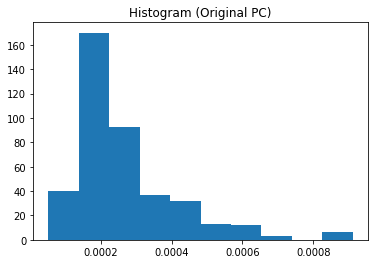

In [ ]:
_ = plt.hist(chamf_list, bins=np.array(bn))
plt.title("Histogram (Original PC)")

In [ ]:
print(min0,min1,maxid0,maxid1,min,max)

2 26 6 14 tensor(5.1408e-05, device='cuda:0') tensor(0.0009, device='cuda:0')


In [ ]:
bin,limits=np.histogram(chamf_list, bins=np.array(bn))

In [ ]:
bin

array([ 40, 170,  93,  37,  32,  13,  12,   3,   0,   6])

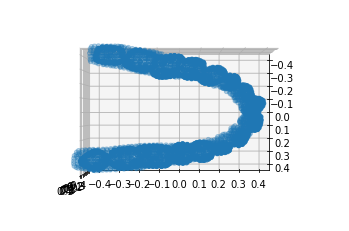

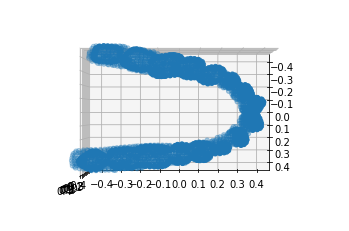

In [ ]:
plot(finalpoints[23],True)
plot (finalpoints[44],True)

In [ ]:
min= 5.1408e-05
max=0.0009

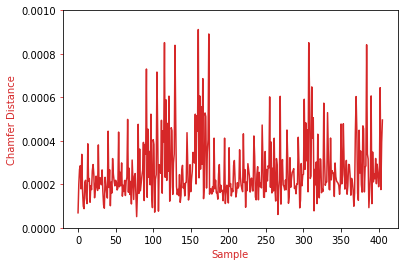

In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(chamf_list,color=color)
ax1.set_xlabel('Sample',color=color)
ax1.set_ylim(0,0.001)
ax1.set_ylabel('Chamfer Distance',color=color)
ax1.tick_params(axis='y', color=color)
    

# Remove 

In [ ]:
dist = np.load('./PC_Arrays/Data_Dist2.npy',allow_pickle=True)
finalpoints = np.load('./PC_Arrays/finalpoints22048.npy',allow_pickle=True)
DATA_DIR=''
#0 train

In [ ]:
dist[0].shape

(15,)

In [ ]:
dist[0]

array([22,  1,  2, 25,  3, 21, 26, 18, 29, 20,  7, 10, 14, 19,  6])

In [ ]:
finalpoints.shape

(240, 2048, 3)

In [ ]:
finalpoints.shape[0]

240

In [ ]:
min= 5.7387e-05
max=0.0009
org_size=30

In [ ]:
PCs=finalpoints[30:]
PCs.shape

(210, 2048, 3)

In [ ]:
pointsAE = np.load('./PC_Arrays/finalpoints22048.npy',allow_pickle=True)
#pointsAE= (pointsAE + (-0.5)) / (0.5 - (-0.5))

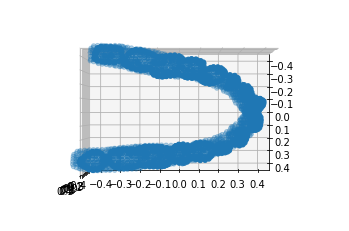

In [ ]:
plot(pointsAE[1],True)

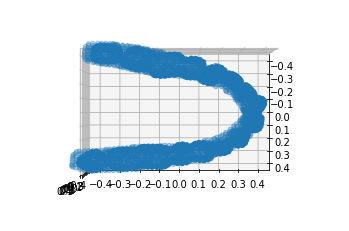

In [ ]:
plot(PCs[1],True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
100%|██████████| 210/210 [00:00<00:00, 516.90it/s]


Removed Points: 0 .Remaining Points: 210
Average: 0.00021849442 Std 5.4393076e-05


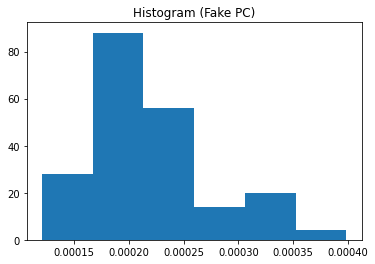

In [ ]:
remove=Filter1(PCs)

In [ ]:
PCs2,zf2=RemovePCs(remove=remove,PCs=PCs,z=[])

In [ ]:
chamf_list=chamf_Mat(it=0,PCs=PCs2)

  0%|          | 0/210 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
100%|██████████| 210/210 [01:17<00:00,  2.73it/s]


In [ ]:
remove=Filter2(chamf_list)

In [ ]:
PCs3,zf3=RemovePCs(remove=remove,PCs=PCs2,z=[])
len(PCs3)

175

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
100%|██████████| 175/175 [00:00<00:00, 530.99it/s]


Removed Points: 0 .Remaining Points: 175
Average: 0.00022286836 Std 5.6748915e-05


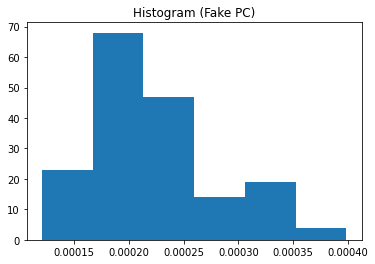

In [ ]:
_=Filter1(PCs3)

In [ ]:
X_train=finalpoints[dist[0]]
X_test=finalpoints[dist[1]]
print(len(X_train),len(X_test))

15 15


In [ ]:
pointsAE=[]
for i in range(len(X_test)):
    pointsAE.append(X_test[i])
for i in range(len(X_train)):
    pointsAE.append(X_train[i])
for i in range(len(PCs3)):
    pointsAE.append(PCs3[i])
pointsAE=np.array(pointsAE)
np.save('PC_Arrays/pointsAE-'+str(final_points.shape)+'.npy', pointsAE)

In [ ]:
pointsAE.shape

(205, 2048, 3)

In [ ]:
final_points.shape

(240, 2048, 3)

# Histogram

In [ ]:
pointsAE = np.load('./PC_Arrays/pointsAE-(240, 2048, 3).npy',allow_pickle=True)

In [ ]:
pointsAE.shape

(205, 2048, 3)

In [ ]:
aligned_Tensor = PointcloudDatasetNoisy('DATA_DIR', pointsAE)
aligned_dataloader = DataLoader(aligned_Tensor, num_workers=0, shuffle=True, batch_size=1)

In [ ]:
chamf_list=[]
zeros=[]
x=aligned_dataloader.dataset[0].float().to(device)
x= x.unsqueeze(0)
for j in range(30):
    y=aligned_dataloader.dataset[j].float().to(device)
    y= y.unsqueeze(0)
    loss_chamf,_=chamfer_distance(x,y)
    chamf_list.append(loss_chamf.detach().cpu().numpy())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [ ]:
#Sturge’s Rule
bn=int(np.round(1+3.322*np.log10(30)))

In [ ]:
bn

6

Text(0.5, 1.0, 'Histogram (Original PC)')

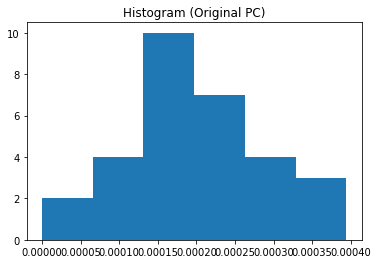

In [ ]:
#_ = plt.hist(chamf_list, bins=np.array(8))
_ = plt.hist(chamf_list, bins=bn)
plt.title("Histogram (Original PC)")

In [ ]:
bin,limits=np.histogram(chamf_list, bins=bn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


Text(0.5, 1.0, 'Histogram (Generated PC)')

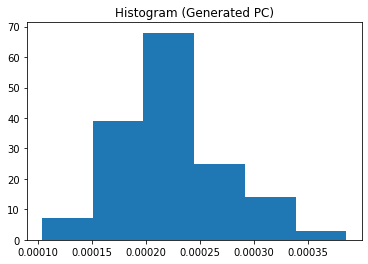

In [ ]:
chamf_list2=[]
for i in range(1):
  x=aligned_dataloader.dataset[0].float().to(device)
  x= x.unsqueeze(0)
  for j in range(30,len(pointsAE)):
    y=aligned_dataloader.dataset[j].float().to(device)
    y= y.unsqueeze(0)
    loss_chamf,_=chamfer_distance(x,y)
    chamf_list2.append(loss_chamf.detach().cpu().numpy())
_ = plt.hist(chamf_list2, bins=bn)
plt.title("Histogram (Generated PC)")

In [ ]:
bin2,limits2=np.histogram(chamf_list2, bins=bn)
limits2

array([0.00010351, 0.00015048, 0.00019745, 0.00024443, 0.0002914 ,
       0.00033838, 0.00038535], dtype=float32)

In [ ]:
print(np.mean(chamf_list2),np.std(chamf_list2))

0.00022321458 4.9926188e-05


In [ ]:
print(np.mean(chamf_list),np.std(chamf_list))

0.0002044921 8.699671e-05


In [ ]:
bin

array([ 2,  4, 11, 13,  7,  3])

In [ ]:
bin2

array([ 2,  7, 50, 82, 33,  6])

In [ ]:
binsf=bin*len(pointsAE)/30

In [ ]:
binsf

array([12., 24., 66., 78., 42., 18.])

In [ ]:
binsf=np.ceil(binsf)
print(binsf)

[12. 24. 66. 78. 42. 18.]


In [ ]:
keep=[]
b1=0
b2=0
b3=0
b4=0
b5=0
b6=0
for i in range(len(chamf_list2)):
  if chamf_list2[i]>0 and chamf_list2[i]<=limits2[1] and b1<=binsf[0]:
    keep.append(i)
    b1=b1+1
  if chamf_list2[i]>limits2[1] and chamf_list2[i]<=limits2[2] and b2<=binsf[1]:
    keep.append(i)
    b2=b2+1
  if chamf_list2[i]>limits2[2] and chamf_list2[i]<=limits2[3] and b3<=binsf[2]:
    keep.append(i)
    b3=b3+1
  if chamf_list2[i]>limits2[3] and chamf_list2[i]<=limits2[4] and b4<=binsf[3]:
    keep.append(i)
    b4=b4+1
  if chamf_list2[i]>limits2[4] and chamf_list2[i]<=limits2[5] and b5<=binsf[4]:
    keep.append(i)
    b5=b5+1
  if chamf_list2[i]>limits2[5] and b6<=binsf[5]:
    keep.append(i)
    b6=b6+1
np.save('PC_Arrays/keep2.npy', keep)
  
  

In [ ]:
pointsAE3=[]
for i in range(len(pointsAE)):
  if  i <30:
    pointsAE3.append(pointsAE[i])
  else:
    if  i in keep:
      pointsAE3.append(pointsAE[i])
pointsAE3=np.array(pointsAE3)
np.save('PC_Arrays/pointsAE3-2-'+str(pointsAE.shape[1])+'.npy', pointsAE3)

In [ ]:
pointsAE3.shape

(177, 2048, 3)

In [ ]:
aligned_Tensor = PointcloudDatasetNoisy("DATA_DIR", pointsAE3)
aligned_dataloader = DataLoader(aligned_Tensor, num_workers=0, shuffle=True, batch_size=1)

In [ ]:
len(aligned_dataloader)

177

In [ ]:
chamf_list=[]
zeros=[]
for i in range(1):
  x=aligned_dataloader.dataset[0].float().to(device)
  x= x.unsqueeze(0)
  for j in range(len(pointsAE3)):
    y=aligned_dataloader.dataset[j].float().to(device)
    y= y.unsqueeze(0)
    loss_chamf,_=chamfer_distance(x,y)
    chamf_list.append(loss_chamf.detach().cpu().numpy())

Text(0.5, 1.0, 'Histogram (Generated PC- Final)')

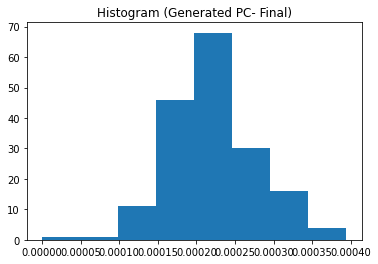

In [ ]:
_ = plt.hist(chamf_list, bins=np.array(8))
plt.title("Histogram (Generated PC- Final)")

In [ ]:
print(np.mean(chamf_list),np.mean(chamf_list[0:40]))

0.00022134812 0.00021239389


In [ ]:
print(np.std(chamf_list),np.std(chamf_list[0:40]))

5.8069763e-05 7.928225e-05


# Generate Noisy Data

In [ ]:
import os
import sys
import tqdm
import torch
import random
import datetime
import open3d as o3d

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from pyntcloud import PyntCloud
from tensorboardX import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

# Load Data and Generate List

In [ ]:
finalpoints = np.load('./PC_Arrays/finalpoints22048.npy',allow_pickle=True)

In [ ]:
pointsAE=[]
a = np.load('./PC_Arrays/FinalPCs-Train-Val-Test.npy',allow_pickle=True)
for i in range(len(a[1])):
  pointsAE.append(a[1][i])
for i in range(len(a[0])):
  pointsAE.append(a[0][i])
#pointsAE=np.array(a)
pointsAE2=np.array(pointsAE)

In [ ]:
pointsAE2=a[1] # Validation Data

pointsAE_Training=a[0]# Training Data

pointsAE2_testing=a[2] # Validation Data

In [ ]:
pointsAE2.shape

(15, 2048, 3)

In [ ]:
shrinkf=[6.25,12.5,15.625,21.875,25,31.25]

In [ ]:
for i in range(len(shrinkf))):
  shrink=shrinkf[0]
  generate_noisy(shrink,pointsAE2,whole=False)

Streaming output truncated to the last 5000 lines.
Reduction Number: 16 /processing sample: 10 /iteration: 2 /shape: 1702 /radius: 0.051799999999998625
Reduction Number: 16 /processing sample: 11 /iteration: 58 /shape: 1703 /radius: 0.05759999999999879
Reduction Number: 16 /processing sample: 12 /iteration: 144 /shape: 1701 /radius: 0.043399999999998384
Reduction Number: 16 /processing sample: 13 /iteration: 1 /shape: 1702 /radius: 0.04349999999999839
Reduction Number: 16 /processing sample: 14 /iteration: 2 /shape: 1701 /radius: 0.04369999999999839
Reduction Number: 17 /processing sample: 0 /iteration: 2 /shape: 1682 /radius: 0.04369999999999839
Reduction Number: 17 /processing sample: 1 /iteration: 1 /shape: 1682 /radius: 0.043799999999998396
Reduction Number: 17 /processing sample: 2 /iteration: 2 /shape: 1680 /radius: 0.0438999999999984
Reduction Number: 17 /processing sample: 3 /iteration: 42 /shape: 1683 /radius: 0.04809999999999852
Reduction Number: 17 /processing sample: 4 /ite

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


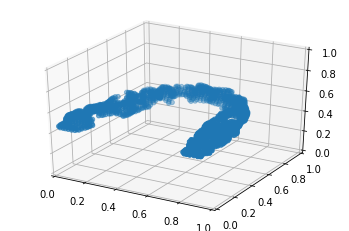

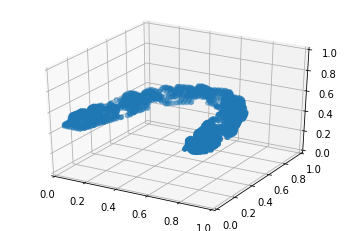

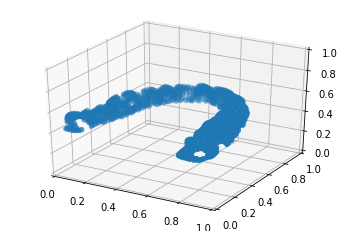

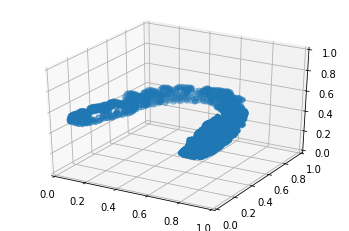

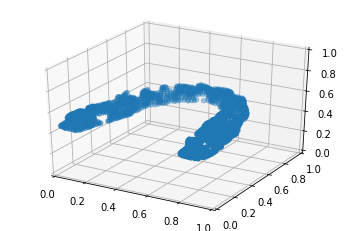

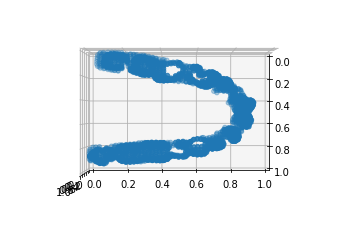

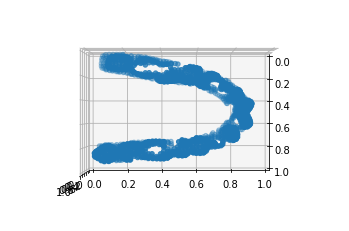

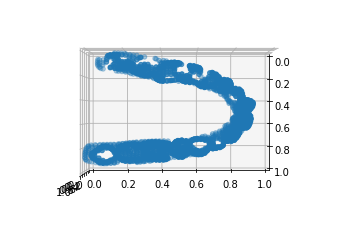

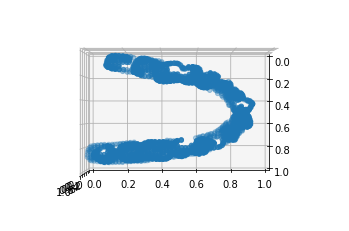

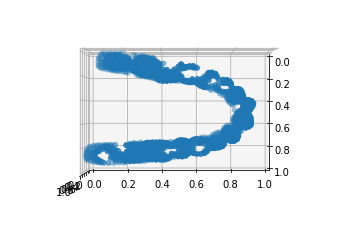

In [ ]:
shrink=20
org_size=2048
list_point_clouds = np.load('PC_Arrays/Validation_Dataset/list_point_noisy-3-'+str(org_size)+'-'+str(shrink)+'.npy')
plotList(5,list_point_clouds, False)
plotList(5,list_point_clouds, True)

In [ ]:
list_point_clouds.shape

(15, 1639, 3)

## Other

In [ ]:
def RemovePoints(ext,shrink):
  DATA_DIR = './2048Samples/'+ext
  directory =DATA_DIR 
  list_point_clouds=[None]*120
  i=0
  for filename in os.listdir(directory):
    list_point_clouds[i]=str(os.path.join(directory, filename))
    i=i+1
  list_new_data = []
  for i in tqdm.trange(len(list_point_clouds)):
    points = PyntCloud.from_file(list_point_clouds[i])
    points = np.array(points.points[0:2048])
    points=points[:,[0,1,2]]
    points = points.astype(np.float)
    seed_idx = int(np.random.rand() * 2048 * shrink/100)
    points_removed = np.concatenate((points[:seed_idx, :], points[seed_idx + int(((100-shrink)/100)*2048):, :]), axis=0)
    list_new_data.append(points_removed)
  np.save('list_point_noisy.npy', list_new_data)
  return list_new_data

In [ ]:
list_point_clouds = np.load('./list_point_noisy.npy')

In [ ]:
  DATA_DIR = './2048Samples/'+ext
  directory =DATA_DIR 
  list_point_clouds=[None]*120
  i=0
  for filename in os.listdir(directory):
    list_point_clouds[i]=str(os.path.join(directory, filename))
    i=i+1

In [ ]:
list_point_clouds[0]

'./2048Samples/2021-08-30 21:26:28.617917/Sample:0-Degrees:1 de.ply'

In [ ]:
 points = PyntCloud.from_file(list_point_clouds[0])

In [ ]:
points.points

,x,y,z,nx,ny,nz
0,0.242183,0.256524,0.106727,0.296360,-0.498744,0.814510
1,-0.001702,0.388168,0.110768,-0.085978,0.452697,0.887509
2,-0.060325,0.411608,0.108824,-0.023840,0.582255,0.812657
3,-0.042438,0.380399,0.107609,0.112817,-0.647889,0.753334
4,0.031572,0.371169,0.110983,0.015262,-0.681368,0.731782
...,...,...,...,...,...,...
2044,-0.433228,-0.082565,0.045556,0.885209,0.042056,0.463288
2045,0.395742,-0.200493,0.046912,-0.086931,-0.019397,0.996025
2046,-0.234038,0.123823,0.010654,-0.918778,-0.370058,0.137495
2047,-0.415103,-0.395713,0.046782,-0.025269,-0.051165,0.998370


In [ ]:
list_point_clouds[0].shape

(1639, 3)

# Create Mesh

In [ ]:
#READ
ext='2021-08-31 00:24:19.543706'
Dir='/content/gdrive/MyDrive/MSEC2022/MoldScan/2048Samples/'
directory = r'/'+Dir[1:]+ext+'/'
list_point_clouds=[]
for filename in os.listdir(directory):
  list_point_clouds.append(str(os.path.join(directory, filename)))
list_point_clouds[119]


'/content/gdrive/MyDrive/MSEC2022/MoldScan/2048Samples/2021-08-30 21:26:28.617917/MirrorSample:59-Degrees:20.1.ply'

In [ ]:
pcd = o3d.io.read_point_cloud(names[20],format='xyzn')
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]
bbox = pcd.get_axis_aligned_bounding_box() 
p_mesh_crop = poisson_mesh.crop(bbox)

In [ ]:
o3d.io.write_triangle_mesh(Dir+'Sample20.obj', p_mesh_crop)

True

# Pytorch 3D

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.9") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{torch.__version__[0:5:2]}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py37_cu102_pyt190/download.html
     |████████████████████████████████| 33.8 MB 81 kB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 636 kB 17.7 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20210825-py3-none-any.whl size=60661 sha256=dbde213c57d3d3b5a64ba48f39045d5a3326b96306a7e4b2642387c1dba56dc8
  Stored in directory: /root/.cache/pip/wheels/53/c4/f8/c4cb07f135845218b019b4a55d8a0470a0f21ee13f8dcd16be
Successfully built fvcore
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
#%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

# Mold Example

In [ ]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [ ]:
#READ
ext='2021-08-31 00:24:19.543706'
Dir='/content/gdrive/MyDrive/MSEC2022/MoldScan/2048Samples/'
directory = r'/'+Dir[1:]+ext+'/'
list_point_clouds=[]
for filename in os.listdir(directory):
  list_point_clouds.append(str(os.path.join(directory, filename)))
i=1
list_point_clouds[2]

'/content/gdrive/MyDrive/MSEC2022/MoldScan/2048Samples/2021-08-31 00:24:19.543706/Sample:2-Degrees:4 de.obj'

In [ ]:
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(list_point_clouds[1])

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [ ]:
verts.shape

torch.Size([87627, 3])

In [ ]:
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(list_point_clouds[2])

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
src_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [ ]:
verts.shape

torch.Size([87676, 3])

In [ ]:
plot_pointcloud(trg_mesh, "Target mesh")

NameError: ignored

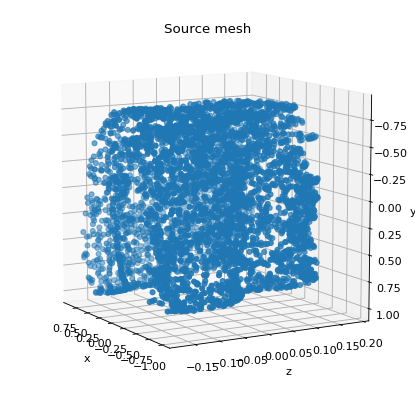

In [ ]:
plot_pointcloud(src_mesh, "Source mesh")

In [ ]:
sample_trg = sample_points_from_meshes(trg_mesh, 2048)
sample_src = sample_points_from_meshes(src_mesh, 2048)

In [ ]:
loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

In [ ]:
print(loss_chamfer)

tensor(0.0023, device='cuda:0')


In [ ]:
sample_trg.shape

torch.Size([1, 2048, 3])

In [ ]:
p1=sample_trg.detach().cpu().numpy()

(-1.0, 1.0)

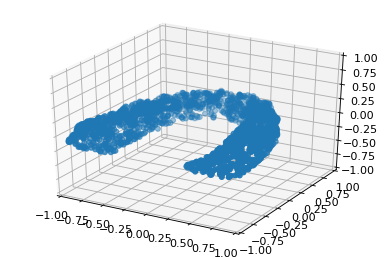

In [ ]:
inputt = p1[0,:,:]
fig = plt.figure()
ax_x = fig.add_subplot(111, projection='3d')
x_ = inputt
ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2])
ax_x.set_xlim([-1,1])
ax_x.set_ylim([-1,1])
ax_x.set_zlim([-1,1])

In [ ]:
df = pd.DataFrame(x_, columns=['X axis', 'Y axis', 'Z axis'])
namefile=str(i)+':Sample.txt'
df.to_csv(r'/'+Dir[1:]+namefile, header=None, index=None, sep=' ', mode='a')

In [ ]:
'/'+Dir[1:]+namefile

'/content/gdrive/MyDrive/MSEC2022/MoldScan/2048Samples/1:Sample.txt'

In [ ]:
cloud = PyntCloud.from_file('/'+Dir[1:]+namefile,sep=" ",names=["x","y","z"])
nameply=str(np.ceil((i+1)/3)-1)+':input.ply'
cloud.to_file(Dir+nameply)

In [ ]:
np.max(inputt)

0.9466199

# General iteration

In [ ]:
directory = r'/content/gdrive/MyDrive/MSEC2022/MoldScan/asc/'
names=[None]*60
i=0
for filename in os.listdir(directory):
  names[i]=str(os.path.join(directory, filename))
  i=i+1
names[59]

'/content/gdrive/MyDrive/MSEC2022/MoldScan/asc/20.1 and 39.9 degree rotation.asc'

In [ ]:
ROOT_DIR = './2048Samples/'+str(datetime.datetime.now())+'/'
if not os.path.exists(ROOT_DIR):
  os.makedirs(ROOT_DIR)
for i in range(len(names)):
  print("Processing file:",i)
  pcd = o3d.io.read_point_cloud(names[i],format='xyzn')
  poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]
  bbox = pcd.get_axis_aligned_bounding_box() 
  p_mesh_crop = poisson_mesh.crop(bbox)
  namefile='Sample:'+str(i)+'-Degrees:'+names[i][46:50]+'.obj'
  o3d.io.write_triangle_mesh(ROOT_DIR+namefile, p_mesh_crop)


Processing file: 0
Processing file: 1
Processing file: 2
Processing file: 3
Processing file: 4
Processing file: 5
Processing file: 6
Processing file: 7
Processing file: 8
Processing file: 9
Processing file: 10
Processing file: 11
Processing file: 12
Processing file: 13
Processing file: 14
Processing file: 15
Processing file: 16
Processing file: 17
Processing file: 18
Processing file: 19
Processing file: 20
Processing file: 21
Processing file: 22
Processing file: 23
Processing file: 24
Processing file: 25
Processing file: 26
Processing file: 27
Processing file: 28
Processing file: 29
Processing file: 30
Processing file: 31
Processing file: 32
Processing file: 33
Processing file: 34
Processing file: 35
Processing file: 36
Processing file: 37
Processing file: 38
Processing file: 39
Processing file: 40
Processing file: 41
Processing file: 42
Processing file: 43
Processing file: 44
Processing file: 45
Processing file: 46
Processing file: 47
Processing file: 48
Processing file: 49
Processing

# Example

In [ ]:
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

--2021-09-01 20:45:12--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj’

dolphin.obj         100%[===================>] 153.09K  --.-KB/s    in 0.03s   

2021-09-01 20:45:12 (5.17 MB/s) - ‘dolphin.obj’ saved [156763/156763]



In [ ]:
# Load the dolphin mesh.
trg_obj = os.path.join('dolphin.obj')

In [ ]:
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [ ]:
# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

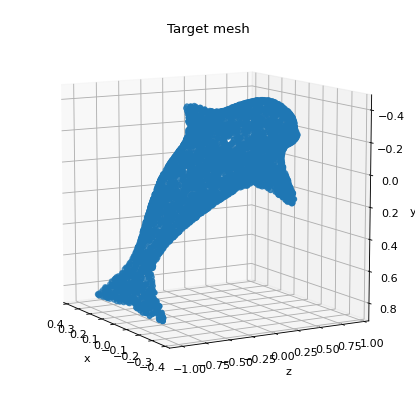

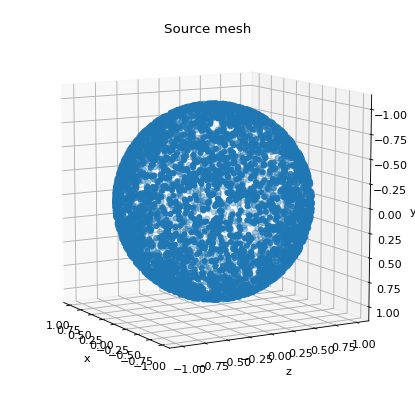

In [ ]:
# %matplotlib notebook
plot_pointcloud(trg_mesh, "Target mesh")
plot_pointcloud(src_mesh, "Source mesh")

In [ ]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [ ]:
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [ ]:
sample_trg = sample_points_from_meshes(trg_mesh, 2000)
sample_src = sample_points_from_meshes(src_mesh, 5000)
sample_trg.shape

torch.Size([1, 2000, 3])

In [ ]:
sample_src.shape

torch.Size([1, 5000, 3])

In [ ]:
loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
print(loss_chamfer)

tensor(0.6739, device='cuda:0')


  0%|          | 0/2000 [00:00<?, ?it/s]

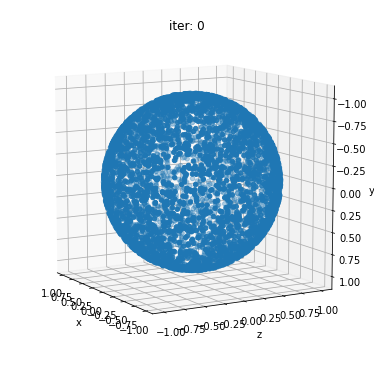

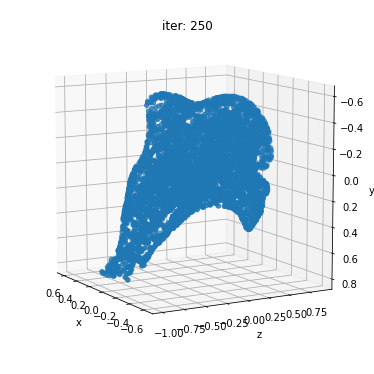

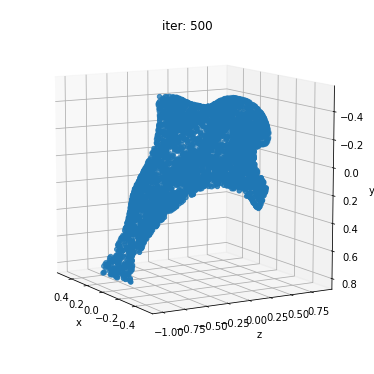

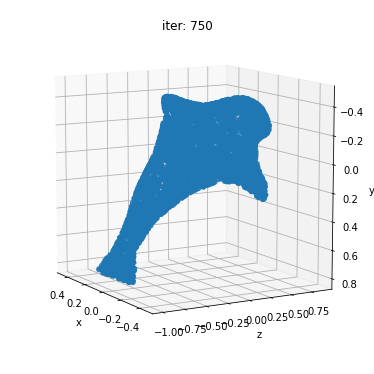

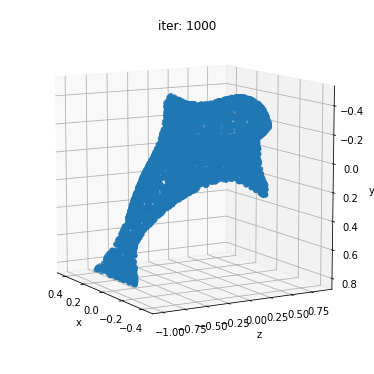

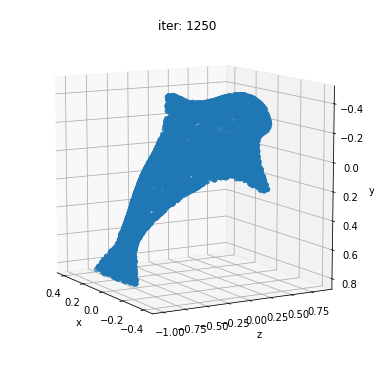

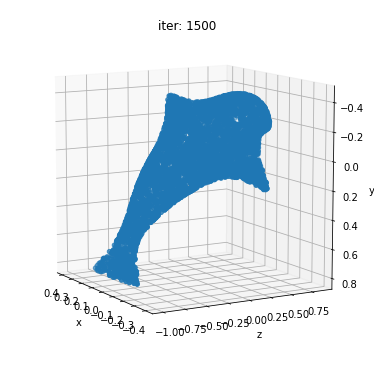

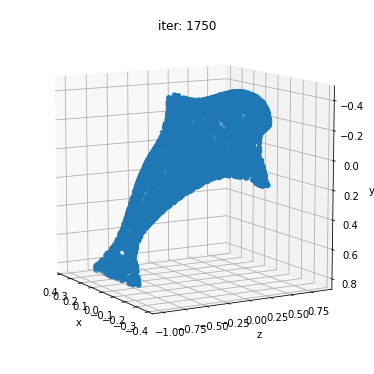

In [ ]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        
    # Optimization step
    loss.backward()
    optimizer.step()


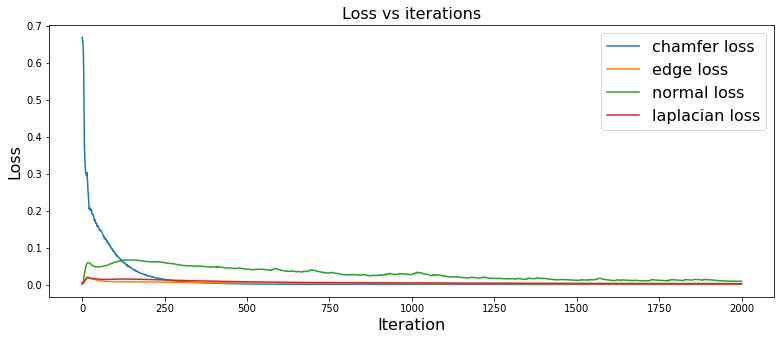

In [ ]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

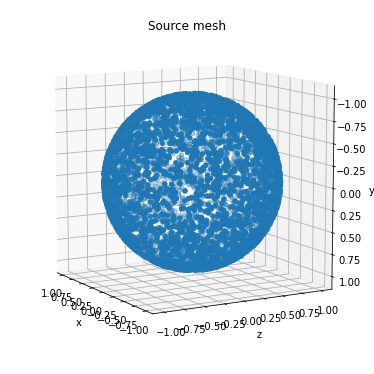

In [ ]:
plot_pointcloud(src_mesh, "Source mesh")

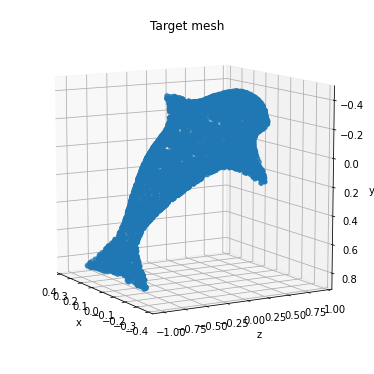

In [ ]:
plot_pointcloud(trg_mesh, "Target mesh")

# ASD